In [124]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import ta
import pickle
from gym_anytrading.envs import StocksEnv,Actions,Positions
from stable_baselines3 import PPO, A2C
from sb3_contrib import RecurrentPPO
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [125]:
window_size = 20 
start_date = '2024-01-01'
today = datetime.today().date()
end_date = today.strftime("%Y-%m-%d")

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('columns_to_scale.pkl', 'rb') as f:
    columns_to_scale = pickle.load(f)

# 1. Custom Environment

In [126]:
class CustomStocksEnv(StocksEnv):
    def __init__(self, df, window_size, frame_bound, render_mode=None):
        super().__init__(df, window_size, frame_bound, render_mode)

        self.trade_fee_bid_percent = 0.001  # unit
        self.trade_fee_ask_percent = 0.001 
    
    def _process_data(self):
        start = self.frame_bound[0] - self.window_size
        end = self.frame_bound[1]
        prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
        signal_features = self.df.drop(['Close'],axis=1).to_numpy()[start:end]
    
        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff, signal_features))
    
        close_col_idx = self.df.columns.get_loc('Close')
        close_mean = scaler.mean_[close_col_idx]
        close_scale = scaler.scale_[close_col_idx]
        # invert scaling
        prices = prices * close_scale + close_mean
        
        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


In [128]:
def load_data(ticker):
    stock_data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='1d')
    
    df = stock_data.reset_index()#[['Date','Close']]
    
    df.sort_values(by=['Date'], inplace=True)
    
    data = df.copy()
    
    # Calculate Simple Moving Average (SMA)
    data['sma'] = ta.trend.sma_indicator(data['Close'], window=10)
    
    # Calculate Exponential Moving Average (EMA)
    data['ema'] = ta.trend.ema_indicator(data['Close'], window=10)
    
    # Calculate Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(data['Close'])
    data['macd'] = macd.macd()
    data['macd_signal'] = macd.macd_signal()
    data['macd_diff'] = macd.macd_diff()
    
    # Calculate Stochastic Oscillator
    stochastic_osc = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=10, smooth_window=3)
    data['stoch'] = stochastic_osc.stoch()
    data['stoch'].replace([-float('inf'), float('inf')], np.nan, inplace=True)
    data['stoch_signal'] = stochastic_osc.stoch_signal()
    
    # Calculate Relative Strength Index (RSI)
    data['rsi'] = ta.momentum.rsi(data['Close'], window=10)
    
    # Calculate Average True Range (ATR)
    data['atr'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=10)
    
    # Calculate Accumulation Distribution Index (ADI)
    data['adi'] = ta.volume.acc_dist_index(data['High'], data['Low'], data['Close'], data['Volume'])
    data['adi'].replace([np.inf, -np.inf], 0, inplace=True)
    
    # Calculate Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
    data['bollinger_hband'] = bollinger.bollinger_hband()
    data['bollinger_lband'] = bollinger.bollinger_lband()
    data['bollinger_mavg'] = bollinger.bollinger_mavg()
    
    #Commodity Channel Index (CCI)
    data['cci'] = ta.trend.cci(data['High'], data['Low'], data['Close'], window=20)
    
    # Aroon Indicator
    aroon = ta.trend.AroonIndicator(high=data['High'], low=data['Low'], window=25)
    data['aroon_up'] = aroon.aroon_up()
    data['aroon_down'] = aroon.aroon_down()
    
    # Williams %R
    data['williams_r'] = ta.momentum.williams_r(data['High'], data['Low'], data['Close'], lbp=10)
    data['williams_r'].replace([-float('inf'), float('inf')], np.nan, inplace=True)
    
    
    # Money Flow Index (MFI)
    data['mfi'] = ta.volume.money_flow_index(data['High'], data['Low'], data['Close'], data['Volume'], window=10)
    
    # Rate of Change (ROC)
    data['roc'] = ta.momentum.roc(data['Close'], window=10)
    
    # Chaikin A/D Line
    data['chaikin_ad'] = ta.volume.ChaikinMoneyFlowIndicator(data['High'], data['Low'], data['Close'], data['Volume'], window=20).chaikin_money_flow()
    
    # On-Balance Volume (OBV)
    data['obv'] = ta.volume.on_balance_volume(data['Close'], data['Volume'])
    
    #Remove null values and unecessary columns
    data = data.dropna() 
    data.drop(['Dividends','Stock Splits'],axis=1, inplace=True)

    #Scaling
    data[columns_to_scale] = scaler.transform(data[columns_to_scale])
    data.set_index('Date', inplace=True)

    return data

def make_pred(df,model_type,window_size=window_size):
    test_env = CustomStocksEnv(df=df, window_size=window_size, frame_bound=(window_size, len(df)))

    if model_type == 'PPO':
        model_path =  './logs/best_model/best_model.zip'
    elif model_type == 'RecurrentPPO':
        model_path =  './logs/best_model_lstm/best_model.zip'
    elif model_type == 'A2C':
        model_path =  './logs/best_model_a2c/best_model.zip'
    else:
        print("Invalid model. Only accept: 'PPO', 'RecurrentPPO', 'A2C'")
        return None
    
    final_model = PPO.load(model_path)
    
    obs, info = test_env.reset()
    rewards = []
    while True:
        action, _states = final_model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        if done:
            print("Final info:", info)
            break
    
    plt.figure(figsize=(15, 6))
    plt.cla()
    test_env.unwrapped.render_all()
    #plt.savefig(f"predictions_{model_type}.pdf")  ## Save fig
    plt.show()
    test_env.close()

# 2. Make Predictions

In [129]:
df = load_data('AMD') #All models result in loss 
#df = load_data('INTC') #Some still profit even the stock price is decreasing
#df = load_data('AVGO') #All models profit but not better than holding all the time
#df = load_data('ARM') #RecurrentPPO beats the market with 228% profit


Final info: {'total_reward': np.float32(1.4599915), 'total_profit': np.float32(0.9934351), 'position': <Positions.Short: 0>}


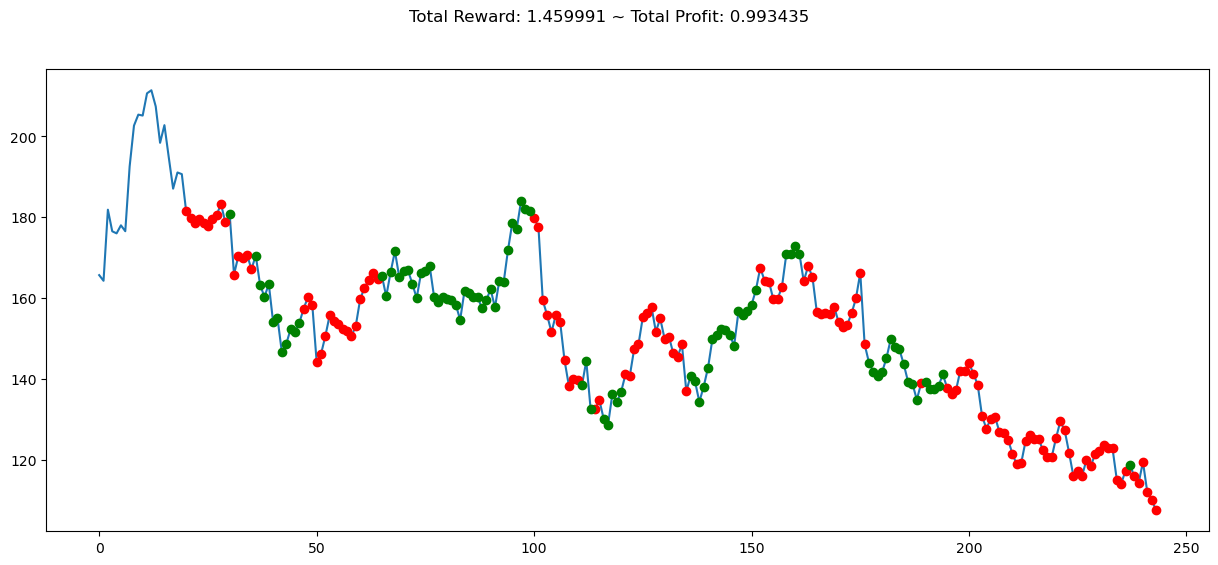

In [130]:
# PPO
make_pred(df,'PPO')

Final info: {'total_reward': np.float32(-33.289986), 'total_profit': np.float32(0.70027834), 'position': <Positions.Long: 1>}


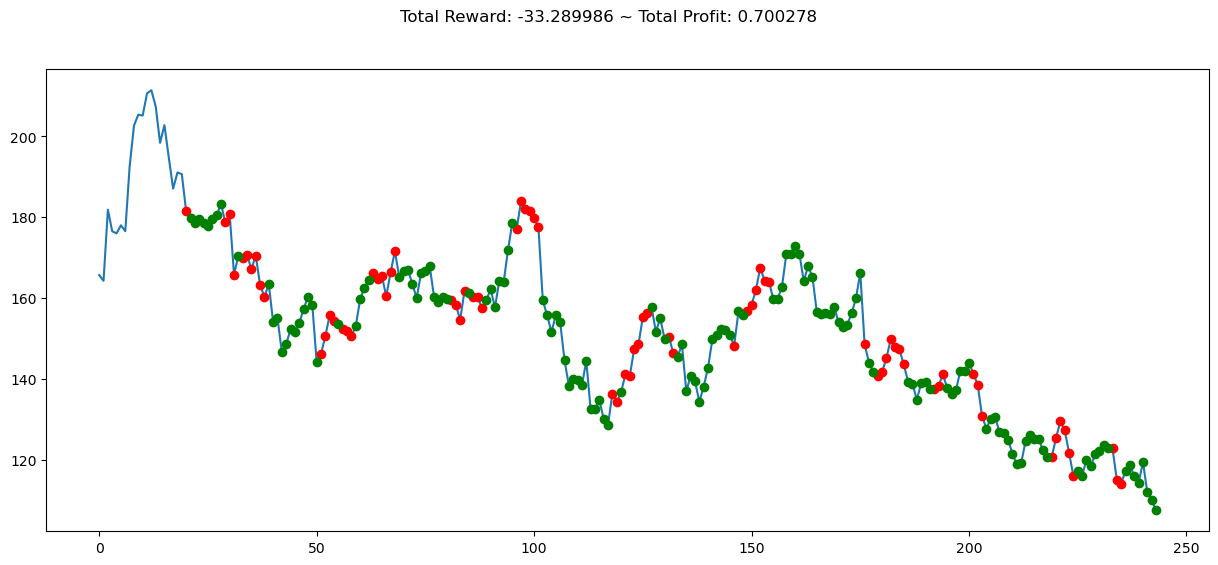

In [131]:
#RecurrentPPO
make_pred(df,'RecurrentPPO') 

Final info: {'total_reward': np.float32(-5.369995), 'total_profit': np.float32(0.9606687), 'position': <Positions.Short: 0>}


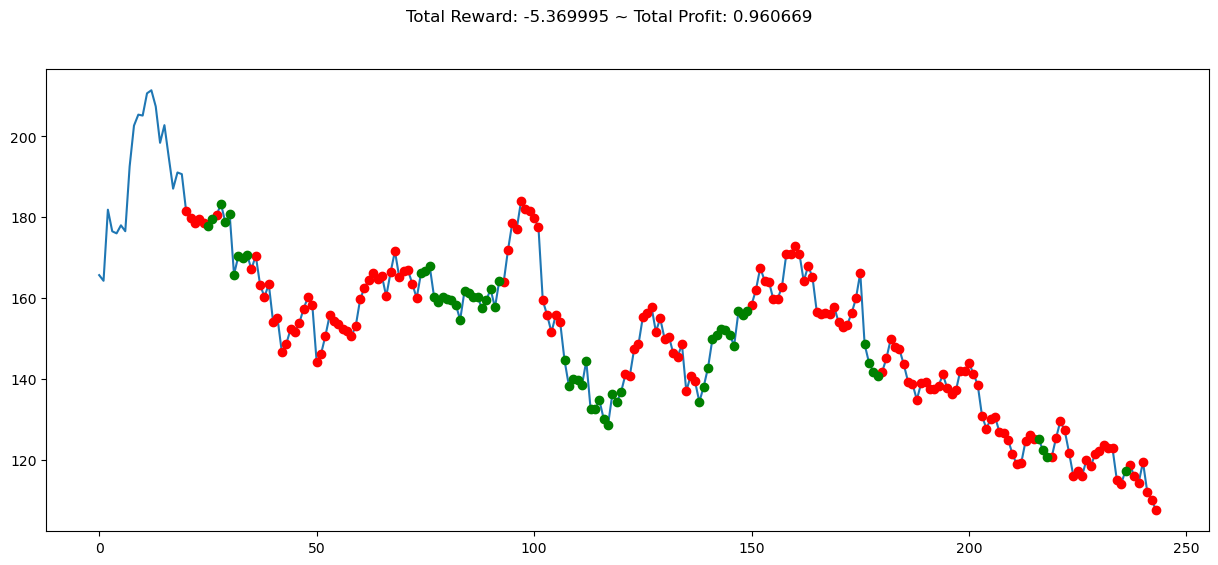

In [132]:
#A2C
make_pred(df,'A2C') 

# 3. Compare Performance(Uptrend, Downtrend, Sideways Trend)

In [133]:
def make_pred(df, model_type, window_size=window_size):
    test_env = CustomStocksEnv(df=df, window_size=window_size, frame_bound=(window_size, len(df)))

    if model_type == 'PPO':
        model_path = './logs/best_model/best_model.zip'
    elif model_type == 'RecurrentPPO':
        model_path = './logs/best_model_lstm/best_model.zip'
    elif model_type == 'A2C':
        model_path = './logs/best_model_a2c/best_model.zip'
    else:
        print("Invalid model. Only accept: 'PPO', 'RecurrentPPO', 'A2C'")
        return None
    
    final_model = PPO.load(model_path)
    
    obs, info = test_env.reset()
    final_info = None  # Variable to store final info
    
    while True:
        action, _states = final_model.predict(obs, deterministic=True)
        
        obs, reward, terminated, truncated, info = test_env.step(action)
        
        if terminated or truncated:
            final_info = info  # Store the final info
            break
    
    test_env.close()
    
    return final_info  # Return extracted info

def compute_buy_hold(df):
    initial_price = df.iloc[0]['Close']
    final_price = df.iloc[-1]['Close']
    
    total_profit = final_price / initial_price 
    total_reward = total_profit - 1 
    
    return total_reward, total_profit

def moving_average_crossover(df, short_window=10, long_window=50):
    """Compute Moving Average Crossover strategy."""
    df = df.copy()
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()
    
    df['Position'] = 0
    df.loc[df['Short_MA'] > df['Long_MA'], 'Position'] = 1  # Buy
    df.loc[df['Short_MA'] < df['Long_MA'], 'Position'] = -1  # Sell
    
    df['Daily_Return'] = df['Close'].pct_change() * df['Position'].shift(1)
    total_profit = (df['Daily_Return'] + 1).cumprod().iloc[-1]
    total_reward = total_profit - 1
    
    return total_reward, total_profit

def run_tests():
    stocks = ['AMD', 'AVGO', 'TEM']
    models = ['PPO', 'RecurrentPPO', 'A2C']
    results = []
    
    for stock in stocks:
        df = load_data(stock)
        
        # Buy & Hold Strategy
        buy_hold_reward, buy_hold_profit = compute_buy_hold(df)
        results.append({'Stock': stock, 'Model': 'Buy&Hold', 'Total Rewards': buy_hold_reward, 'Total Profit': buy_hold_profit})

        # Moving Average Crossover Strategy
        mac_reward, mac_profit = moving_average_crossover(df)
        results.append({'Stock': stock, 'Model': 'MovingAvgCrossover', 'Total Rewards': mac_reward, 'Total Profit': mac_profit})
        
        # Reinforcement Learning Models
        for model in models:
            info = make_pred(df, model)
            if info:
                results.append({'Stock': stock, 'Model': model, 'Total Rewards': info.get('total_reward', 0), 'Total Profit': info.get('total_profit', 0)})
    
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# Run the tests
results_df = run_tests()


   Stock               Model  Total Rewards  Total Profit
0    AMD            Buy&Hold      -0.398608      0.601392
1    AMD  MovingAvgCrossover      -0.236484      0.763516
2    AMD                 PPO       1.459991      0.993435
3    AMD        RecurrentPPO     -33.289986      0.700278
4    AMD                 A2C      -5.369995      0.960669
5    ARM            Buy&Hold       0.399755      1.399755
6    ARM  MovingAvgCrossover      -0.444875      0.555125
7    ARM                 PPO      21.794983      1.155922
8    ARM        RecurrentPPO     117.649956      2.284808
9    ARM                 A2C       7.904991      1.028831
10   TEM            Buy&Hold       1.559089      2.559089
11   TEM  MovingAvgCrossover      -0.971745      0.028255
12   TEM                 PPO      -3.014999      0.920436
13   TEM        RecurrentPPO      27.014992      1.731250
14   TEM                 A2C      24.540001      1.797223


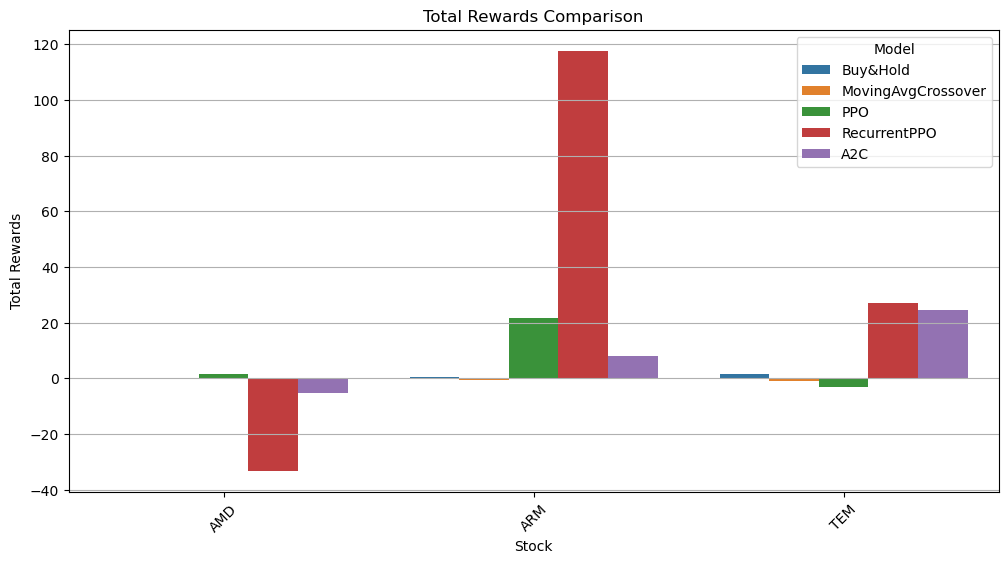

In [134]:
# Set up the figure
plt.figure(figsize=(12, 6), dpi=100)

# Plot total rewards comparison
sns.barplot(data=results_df, x="Stock", y="Total Rewards", hue="Model")
plt.title("Total Rewards Comparison")
plt.xlabel("Stock")
plt.ylabel("Total Rewards")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")

#plt.savefig("total_rewards_comparison.png")
plt.show()

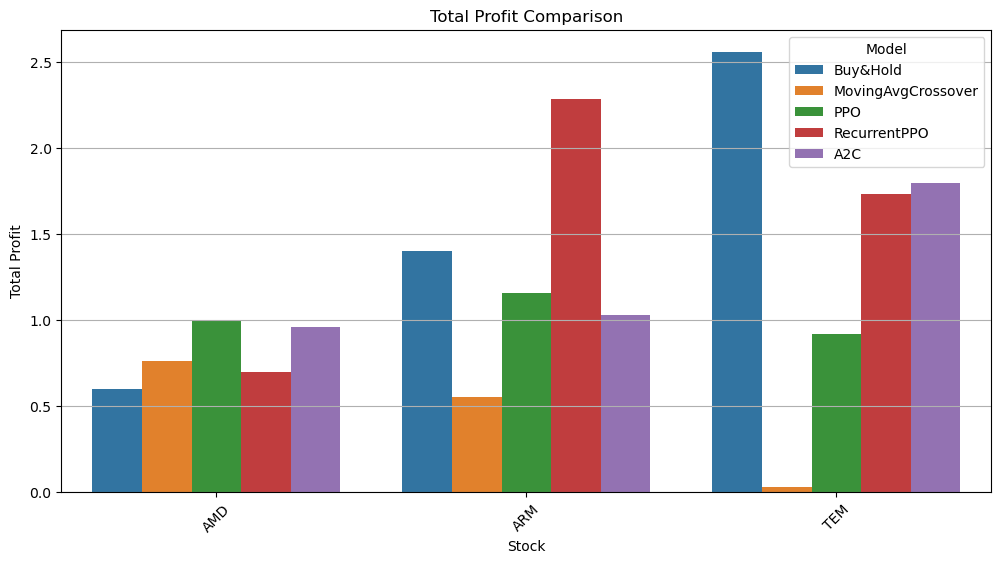

In [135]:
# Set up another figure for total profit
plt.figure(figsize=(12, 6), dpi=100)

# Plot total profit comparison
sns.barplot(data=results_df, x="Stock", y="Total Profit", hue="Model")
plt.title("Total Profit Comparison")
plt.xlabel("Stock")
plt.ylabel("Total Profit")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.grid(axis="y")

#plt.savefig("total_profit_comparison.png")
plt.show()